In this notebook we take the census data and obtain a few key details for each SA1 region, storing each SA1 region as a JSON file. We'll start with just density, zoning, and finance information.

- density info from G01A (Total Persons)
- zoning from the EPI zone WMS
- finance from G02 (median household income)

What else might we want?

In [1]:
import pandas, shapefile
from tqdm import tqdm_notebook as tqdm
import numpy
from matplotlib import pyplot as plt
import json

In [45]:
g02 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G02_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')
g01 = pandas.read_csv(
    '../2016 Census GCP Statistical Area 1 for NSW/'
    '/2016Census_G01_NSW_SA1.csv').set_index('SA1_7DIGITCODE_2016')

In [46]:
g01

,Tot_P_M,Tot_P_F,Tot_P_P,Age_0_4_yr_M,Age_0_4_yr_F,Age_0_4_yr_P,Age_5_14_yr_M,Age_5_14_yr_F,Age_5_14_yr_P,Age_15_19_yr_M,...,High_yr_schl_comp_Yr_8_belw_P,High_yr_schl_comp_D_n_g_sch_M,High_yr_schl_comp_D_n_g_sch_F,High_yr_schl_comp_D_n_g_sch_P,Count_psns_occ_priv_dwgs_M,Count_psns_occ_priv_dwgs_F,Count_psns_occ_priv_dwgs_P,Count_Persons_other_dwgs_M,Count_Persons_other_dwgs_F,Count_Persons_other_dwgs_P
SA1_7DIGITCODE_2016,,,,,,,,,,,,,,,,,,,,,
1100701,140,116,256,6,7,8,15,19,27,9,...,9,0,0,0,119,93,214,22,21,40
1100702,202,175,381,10,3,13,25,22,43,14,...,15,0,0,0,166,151,315,27,15,40
1100703,201,228,428,27,7,34,30,30,67,9,...,11,0,0,0,187,205,389,14,17,30
1100704,189,254,446,15,18,34,31,19,55,9,...,22,0,0,0,172,188,362,29,52,81
1100705,192,208,402,13,9,20,31,15,47,16,...,5,3,3,3,180,187,365,9,17,25
1100706,135,123,249,11,7,18,19,15,39,4,...,6,0,0,0,111,109,221,10,8,15
1100707,190,170,359,9,4,15,15,9,25,6,...,10,0,0,0,159,141,299,26,27,49
1100708,239,225,458,11,14,25,18,27,45,6,...,11,0,0,0,212,198,401,29,18,41
1100709,197,181,380,15,5,20,26,27,53,14,...,8,0,0,0,154,154,306,33,25,55


In [47]:
with open('../zone-info-sydney.json') as f:
    zoning = json.load(f)

In [48]:
with open('../sa1_seven_to_sixteen.json') as f:
    sa1_seven_to_sixteen = json.load(f)

In [49]:
sa1_sixteen_to_seven = {v: k for k, v in sa1_seven_to_sixteen.items()}

In [50]:
zoning = {sa1_sixteen_to_seven[k]: v for k, v in zoning.items()}

In [68]:
pops = g01.Tot_P_P

In [69]:
finance = g02.Median_tot_hhd_inc_weekly

In [70]:
shape = shapefile.Reader('../shapesnsw/MB_2016_NSW')

In [56]:
sa2_to_name = {}
sa2_to_coords = {}
for sr in tqdm(shape.shapeRecords()):
    sa2, name = sr.record.SA1_7DIG16, sr.record.SA2_NAME16
    sa2_to_name[int(sa2)] = name
    if len(sr.shape.points) > 0:
        sa2_to_coords[sa2] = numpy.mean(sr.shape.points, axis=0)

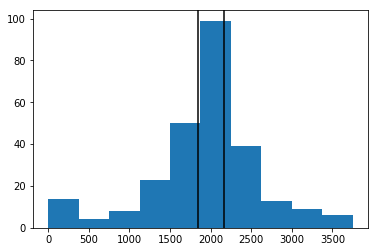

In [57]:
plt.hist(finance)
finance_pc = numpy.percentile(finance[finance > 0], [33, 66])
for p in finance_pc:
    plt.axvline(p, color='k')
finance_pc = numpy.append(finance_pc, 100000)

In [77]:
deets = []
for sa2, pop, fin in zip(g01.index, pops, finance):
    name = sa2_to_name[sa2]
    if str(sa2) not in zoning:
        continue
    deets.append(dict(
        name=name,
        sa2=str(sa2),
        lon=sa2_to_coords[str(sa2)][0],
        lat=sa2_to_coords[str(sa2)][1],
        zoning=zoning[str(sa2)],
        population=pop,
        income=fin,
        income_level=int((fin < finance_pc).argmax() + 1)))

In [78]:
with open('sa2_regions.json', 'w') as f:
    json.dump(deets, f)

In [81]:
# deets

In [74]:
1130301 in g01.index

True